## 나이브 베이즈 알고리즘 예제

![](https://github.com/gusdnd852/bigdata-lecture/blob/master/_notebooks/img/Day4/spam.jpg?raw=true)

나이브 베이즈를 이용해 스펨메일을 필터링 해봅시다. 나이브 베이즈 알고리즘과 함께 여러가지 자연어 처리 기법들을 배워봅시다. 
<br><br>

### 데이터에 대한 설명

이메일의 내용을 갖고서 스팸인지 또는 햄(스팸이 아닌 이메일)인지 분류하는 데이터는 다음과 같은 예제를 갖고 있습니다.


|Class| Text | 
|:----|:-----|
|Spam| free message |
|Ham| send me a messsage |
|Ham| are you free tomorrow? |
|Spam| where is tesseract? |
|Ham| where are you now? |
|Spam| buy awesome tv |

<br>
예를 들어, `I cooked a salmon` 이런 문장인 경우 나이브 베이즈 알고리즘을 사용해서 Spam인지 또는 Ham인지 확률을 알아내는 것이 목표입니다. 베이즈 정리의 문제는 주어지는 데이터의 종속적 관계 때문에 연상량이 급격하게 늘어나게 됩니다. 예를 들어 이메일속의 단어들의 순서는 다른 단어가 나타날 확률을 의미할 수 있으며, 이는 각각의 단어가 다른 단어에 종속적임을 의미하게 됩니다. 예를 들어서 "카지노" 라는 단어가 나오면 그에 따라서 도박과 관련된 단어가 나올 확률이 높을 것 입니다. <br><br>

나이브 베이즈는 이러한 현실적인 가정을 무시하고 모든 단어(또는 features)가 모두 **독립적(Independent)이라고 가정**을 합니다.물론 현실적으로 맞지는 않지만, 그럼에도 불구하고 이러한 가정은 계산량은 줄여주면서 잘 작동합니다. <br><br>

많은 통계학자들이 가정 자체가 틀렸는데 왜 이렇게 잘 작동하는지 많은 연구를 하였는데.. 그중 하나의 설명이 좀 개인적으로 와닿았습니다. 만약 스팸을 정확하게 모두 걸러낸다면 신뢰구간 51% ~ 99%가 의미가 있는 것인가 입니다. 즉 test하면 대부분의 spam을 잘 맞추는데, 확률론적으로 매우 정확한 계산을 해내는 것 자체가 크게 중요하지 않다는 의미입니다. 

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsdata = fetch_20newsgroups(subset='all')
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


- 해당 데이터는 이미 훈련 데이터(11,314개)와 테스트 데이터(7,532개)를 미리 분류해놓았기 때문에 별도로 우리가 훈련 데이터와 테스트 데이터를 분류할 필요는 없다. 위의 코드 부분에 subset 부분에 ‘all’을 넣으면 모든 데이터인 18,846개를 다운로드할 수 있으며, ‘train’을 넣으면 훈련 데이터를, ‘test’를 넣으면 테스트 데이터를 다운로드할 수 있다. newsdata.keys()를 출력하여 해당 데이터가 어떤 속성으로 구성되어져 있는지 출력해보았다.

- 해당 데이터는 data, filenames, target_names, target, DESCR, description이라는 6개 속성의 데이터를 갖고 있는 것을 확인할 수 있다.

In [6]:
%pylab inline
import numpy as np 
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

# 필요한 라이브러리 모두 import

Populating the interactive namespace from numpy and matplotlib


In [14]:
dataset = pd.read_csv('sample_data/spam.csv')
dataset = dataset.iloc[:, 0:2]
dataset.columns = ['class', 'text']

dataset

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ? b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [15]:
dataset.groupby('class').describe()

text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

약 13.5% 만이 spam으로 분류되어 있습니다. 즉 class imbalance(불균형) 문제가 있는 데이터 셋입니다. unique 메세지를 보면 duplicate text가 존재함을 알 수 있습니다. (총 4825개인데 4516개의 unique값이 존재함)
<br><br>

#### 문장 길이 확인하기
또한 아래의 histogram에서 알 수 있듯이, 대부분의 Ham의 글자길이는 대부분 100이하에 있고, Spam의 경우는 150쯤에 있습니다. 즉 길이의 차이가 있으며, Spam이 문장의 길이가 더 깁니다.

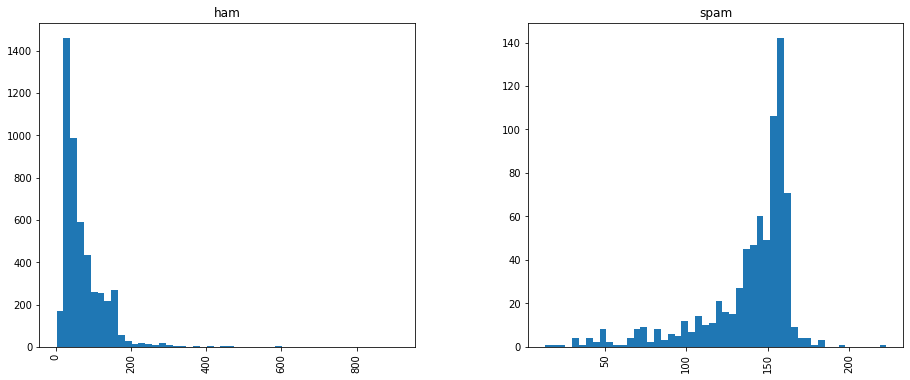

In [16]:
dataset['length'] = dataset['text'].apply(len)
ax = dataset.hist('length', by='class', bins=50, figsize=(15, 6))

이제 데이터를 전처리합니다. 아래와 같은 과정을 거쳐서 데이터를 전처리할 계획입니다.
<br><br>

1. 구두점, Stop Word 제거 : 구두점과 너무 자주 쓰이는 단어들(a, the, of, at 등)을 제거합니다. 이런 단어들(Stop Word)과 구두점들은 스팸이던 햄이던 상관없이 너무 자주 등장하기 때문에 오히려 분류에 방해가 됩니다.

2. Tokenizing : 단어를 띄어쓰기 기준으로 잘라서 리스트로 자릅니다. 단어들은 string이 아니라 list의 타입이 되고, 그 리스트에 단어들이 각각 들어가게 됩니다.

3. Word Encoding : 모든 단어를 숫자로 바꿔줍니다. 하나의 단어는 하나의 고유한 숫자가 됩니다. 컴퓨터는 자연어를 처리할 수 없기 때문에 숫자로 바꿔줘야합니다. (2주차 딥러닝 수업때는 더욱 진보된 워드 임베딩에 대해 배웁니다)

In [17]:
import nltk

nltk.download('stopwords') 
# Stop Word 목록을 다운로드 받습니다.


def preprocess(text):
    
    # Remove Punctuations
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    # Remove stopwords
    cleaned_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return cleaned_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
# 데이터가 많아서 시간이 조금 걸립니다.

dataset['text'].apply(preprocess)

0       [Go, jurong, point, crazy, Available, bugis, n...
1                          [Ok, lar, Joking, wif, u, oni]
2       [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3           [U, dun, say, early, hor, U, c, already, say]
4       [Nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [2nd, time, tried, 2, contact, u, U, 傭50, Poun...
5568                      [b, going, esplanade, fr, home]
5569                     [Pity, mood, Soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [Rofl, true, name]
Name: text, Length: 5572, dtype: object

데이터를 학습/테스트 세트로 분할합니다.

In [19]:
label = dataset['class']
features = dataset['text']

In [29]:

split = int(0.8 * len(dataset)) 

train_feature = features[:split]
train_label = label[:split]

test_feature = features[split:]
test_label = label[split:]

print(train_feature.shape, train_label.shape)
print(test_feature.shape, test_label.shape)

(4457,) (4457,)
(1115,) (1115,)


## Pipeline
이제 학습 파이프라인을 만듭니다. sklearn에서는 Pipeline이라는 클래스로 두 모델을 연결할 수 있습니다. 가장 먼저 `CounterVectorizer`를 이용해 단어를 숫자로 인코딩 한뒤, 인코딩된 숫자를 곧 바로 `NaiveBayes` 모델의 입력으로 넣어서 학습하는 파이프라인을 고안해볼 수 있습니다.

In [21]:
pipeline = Pipeline([
    ('word_encoder', CountVectorizer(analyzer=preprocess)),
    ('classifier', BernoulliNB())
])

pipeline.fit(train_feature, train_label)

Pipeline(steps=[('word_encoder',
                 CountVectorizer(analyzer=<function preprocess at 0x7fdb1741f680>)),
                ('classifier', BernoulliNB())])

In [22]:
pred = pipeline.predict(test_feature)
accuracy_score(test_label, pred)

0.9659192825112107

In [30]:
print(classification_report(test_label, pred))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       970
        spam       0.99      0.74      0.85       145

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



성공적으로 스팸메일을 분류하는데 성공했습니다. 모델을 저장하겠습니다.

In [23]:
# sklearn 모델 저장
import joblib
import os

if not os.path.exists('./models/'):
    os.makedirs('./models/')

joblib.dump(pipeline, './models/naive_bayes.pkl')

['./models/naive_bayes.pkl']

In [24]:
# sklearn 모델 불러오기
import os

if not os.path.exists('./models/'):
    os.makedirs('./models/')

pipeline = joblib.load('./models/naive_bayes.pkl')

#### Ham 데이터 테스트

In [25]:
text_0 = test_feature.iloc[0]
label_0 = test_label.iloc[0]
print('text : ', text_0)
print('label : ', label_0)

text :  Die... I accidentally deleted e msg i suppose 2 put in e sim archive. Haiz... I so sad...
label :  ham


In [26]:
pipeline.predict([text_0])

array(['ham'], dtype='<U4')

#### Spam 데이터 테스트

In [27]:
text_1 = test_feature.iloc[1]
label_1 = test_label.iloc[1]
print('text : ', text_1)
print('label : ', label_1)

text :  Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send \go stop\" to 89123"
label :  spam


In [28]:
pipeline.predict([text_1])

array(['spam'], dtype='<U4')

<br>

### 4. 나이브 베이즈 알고리즘 장점

**나이브 베이즈 알고리즘은 단순하고 빠릅니다.** 나이브 베이즈 알고리즘은 각 데이터들의 연관 관계를 고려하지 않습니다. 독립된 상황에서만 생각하기 때문에 사전 조건이 간단해지므로 결과를 도출하기까지 단순해지고 빠릅니다. 그래서 많은 데이터를 사용할 때 효과적으로 결과를 도출할 수 있습니다. 그렇다면 어떤 데이터들에게 적용시키는 것이 유리할까요? 서로 독립이라고 가정을 하기 때문에 기존 데이터들이 연속적이기보다는 이산적일 때 성능이 좋습니다. (실습때 속도가 느린건 다른 예제에 비해 처리할 데이터가 많아서입니다.)

<br>

### 5. 나이브 베이즈 알고리즘 단점

데이터간의 독립성이 없다면 부정확한 결과가 도출될 수 있습니다. 하나의 데이터가 다른 데이터에 영향이 없는 독립된 상황에서의 사용이 바람직합니다. 한정된 상황에서의 사용과 그로 인한 정확성의 불안정성이 나이브 베이즈 알고리즘의 대표적인 단점으로 볼 수 있습니다. 

<br>

### 6. 나이브 베이즈 모델 종류

`sklearn`은 아래와 같이 다양한 나이브 베이즈 모델을 지원합니다. 여러분의 데이터 분포에 맞는 모델을 사용하시길 바랍니다. (분포 관련된 내용은 검색해보세요!)

- GaussianNB : 정규분포 (클래스 여러개일때 쓰면 좋습니다)
- BernoulliNB : 베르누이분포 (클래스 두개일때 쓰면 좋습니다)